In [3]:
!wget www-personal.umich.edu/~naitian/files/eecs486/cleaned.csv
!wget www-personal.umich.edu/~naitian/files/eecs486/small-images.tar.gz
!tar -xzvf small-images.tar.gz
!rm small-images.tar.gz

Streaming output truncated to the last 5000 lines.
images/EV3SIvmVcAAQP1D.jpg
images/EclwaFxWAAE3sAU.jpg
images/EisQI7qWkAIkXWh.jpg
images/Eg1JVtUXYAQr4xd.jpg
images/EVz0W1sVAAALx-H.jpg
images/EtVif40UUAA_rxb.jpg
images/Ea9wTFPXgAAZNY7.jpg
images/EdeSw32WsAcOO1G.jpg
images/EaFqFu5XgAEBr4b.jpg
images/EflhdsyWoAA9Co-.jpg
images/EfQPTghWkAYynsv.jpg
images/EorzPhhXUAc3Nrs.jpg
images/EYowCO1XsAAKeHl.jpg
images/Ei30StcUcAAZKro.jpg
images/EtQnnlmXAAAUdjZ.jpg
images/EV6nzXaX0AAJ2VW.jpg
images/EtkUaGnXYAAxHd5.jpg
images/EmB5YwPVgAAcg8D.jpg
images/ElXoMMnWMAAElva.jpg
images/Ei31nU-U0AA5TkV.jpg
images/EtWHN2hWgAAx4qm.jpg
images/EWo_qSBXsAgmRJ0.jpg
images/EtfF8G6XMAIZfXK.jpg
images/Ed9y_mYUMAA66Wm.jpg
images/EXSicZIXQAAaORM.jpg
images/EtgNH1zXcAMGhDd.jpg
images/EjgJHs9UwAEuP00.jpg
images/Ek491oSX0AIecQD.jpg
images/ElitRh5X0AE6rex.jpg
images/EcCa7azU8AAxLUi.jpg
images/EfbLqeXXoAADxBc.jpg
images/ErBvJDVXEAAJZMJ.jpg
images/EkEiOmPVkAAsZrA.jpg
images/EcQNfgLXsAAWbKg.jpg
images/EdsPcfMWkAAOV3z.jpg
imag

In [4]:
import re
import math
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import io, utils, transforms, models
from torchsummary import summary

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from tqdm import tqdm

sns.set()

ValueError: ignored

In [ ]:
INPUT_DIM = (224, 224)  # Height x Width

In [ ]:
DEVICE = torch.device("cuda:0")

In [ ]:
class RoomRaterDataset(Dataset):
    """Room raters dataset."""
    def __init__(self, csv_path, root_path="", split="train", transform=None):
        self.split = split
        self.root_path = root_path
        self.transform = transform
        
        self.df = self.preprocess(pd.read_csv(csv_path))
        self.train_split, self.val_split, self.test_split = torch.utils.data.random_split(
            self.df.index,
            [
                math.floor(0.8 * len(self.df)),
                math.floor(0.1 * len(self.df)),
                len(self.df) -  math.floor(0.1 * len(self.df)) -  math.floor(0.8 * len(self.df))
            ],
            generator=torch.Generator().manual_seed(486)
        )
        self.splits = {
            "train": self.train_split,
            "val": self.val_split,
            "test": self.test_split,
        }


    def preprocess(self, df):
        pattern = re.compile(r"https://pbs.twimg.com/(media|tweet_video_thumb)/([\w.\-_]+)")
        def get_path(url):
            if type(url) is not str and np.isnan(url):
                return None
            match = pattern.match(url)
            if match is None:
                print(url)
            return f"images/{match.group(2)}"
        df["img_path"] = df.img_url.apply(get_path)
        df["label"] = (df.rating > df.rating.median()).apply(int)
        df = df.dropna()
        return df

    def load_images(self):
        return self.df.img_path.apply(self.load_image)
    
    
    def load_image(self, img_path):
        try:
            img = io.read_image(
                os.path.join(
                    self.root_path,
                    img_path
                ),
                io.image.ImageReadMode.RGB
            ).float()
            return img
        except Exception as e:
            return torch.zeros((3, INPUT_DIM[0], INPUT_DIM[1]))
            
    def __len__(self):
        return len(self.splits[self.split])

    def __getitem__(self, idx):
        sample = self.load_image(self.df.img_path.loc[self.splits[self.split][idx]])
        label = self.df.label.loc[self.splits[self.split][idx]]
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
# using the validation mean, std because train was too big for my computer. :(
mean, stdev = (torch.tensor([130.7710, 117.8431, 113.5765]), torch.tensor([73.1965, 71.2840, 71.1324]))

In [ ]:
transform = transforms.Compose([
    transforms.Resize(INPUT_DIM),
    transforms.Normalize(mean, stdev),
])
train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(INPUT_DIM),
    transforms.Normalize(mean, stdev),
])
rr_dataset = RoomRaterDataset("./cleaned.csv", root_path="", transform=transform)

In [ ]:
def denormalize(img, stdev, mean):
    return (img * stdev.view(-1, 1, 1) + mean.view(-1, 1, 1)).int()

In [ ]:
grid = utils.make_grid([denormalize(rr_dataset[i][0], stdev, mean) for i in range(9)], nrow=3)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.grid(False)

In [ ]:
model = models.resnet18(pretrained=True)
features = model.fc.in_features
model.fc = nn.Linear(features, 2)

In [ ]:
summary(model.cuda(), (3, 224, 224))

In [ ]:
train = DataLoader(
    RoomRaterDataset("./cleaned.csv", root_path="", split="train", transform=transform),
    batch_size=64,
    shuffle=True
)
val = DataLoader(
    RoomRaterDataset("./cleaned.csv", root_path="", split="val", transform=transform),
    batch_size=128,
    shuffle=False
)
test = DataLoader(
    RoomRaterDataset("./cleaned.csv", root_path="", split="test", transform=transform),
    batch_size=128,
    shuffle=False
)

train_log = []


def train_model(model, optim, crit, scheduler, epochs=20):
  model.cuda()
  for epoch in range(epochs):
    print(f"Epoch {epoch}")
    epoch_data = {}

    model.train()
    true_labels, pred_labels = [], []
    loss_sum, loss_ct = 0, 0
    for X, y in tqdm(train):
      X, y = X.cuda(), y.cuda()
      optim.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        loss = crit(outputs, y)
        loss.backward()
        optim.step()
        if scheduler:
          scheduler.step()
        true_labels += y.cpu()
        pred_labels += pred.cpu()
        loss_sum += loss
        loss_ct += 1

    print(f"=== Train loss of {loss_sum / loss_ct:.4f}")
    print(f"=== Train acc of {accuracy_score(true_labels, pred_labels):.4f}")
    epoch_data["train_loss"] = loss_sum / loss_ct
    epoch_data["train_acc"] = accuracy_score(pred_labels, true_labels)
    epoch_data["train_f1"] = f1_score(pred_labels, true_labels)

    model.eval()
    true_labels, pred_labels = [], []
    loss_sum, loss_ct = 0, 0
    for X, y in (val):
      X, y = X.cuda(), y.cuda()
      optim.zero_grad()

      with torch.set_grad_enabled(False):
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        loss = crit(outputs, y)
        true_labels += y.cpu()
        pred_labels += pred.cpu()
        loss_sum += loss
        loss_ct += 1

    epoch_data["val_loss"] = loss_sum / loss_ct
    epoch_data["val_acc"] = accuracy_score(pred_labels, true_labels)
    epoch_data["val_f1"] = f1_score(pred_labels, true_labels)
    train_log.append(epoch_data)
    print(f"=== Val loss of {loss:.4f}")
    print(f"=== Val acc of {accuracy_score(true_labels, pred_labels):.4f}")

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()
# sched = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)

train_model(model, optim, crit, None, epochs=1)

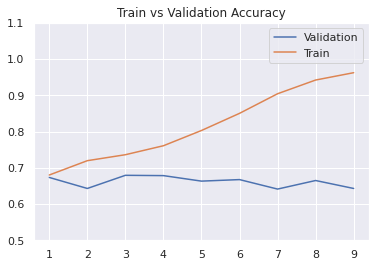

In [ ]:
plt.figure()
plt.ylim(0.5, 1.1)
plt.title("Train vs Validation Accuracy")
plt.plot(list(range(1,len(train_log) + 1)), [t["val_acc"] for t in train_log], label="Validation")
plt.plot(list(range(1,len(train_log) + 1)), [t["train_acc"] for t in train_log], label="Train")
plt.legend()

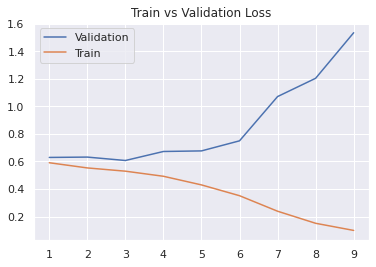

In [ ]:
plt.figure()
# plt.ylim(0.5, 1.1)
plt.title("Train vs Validation Loss")
plt.plot(list(range(1,len(train_log) + 1)), [t["val_loss"] for t in train_log], label="Validation")
plt.plot(list(range(1,len(train_log) + 1)), [t["train_loss"] for t in train_log], label="Train")
plt.legend()

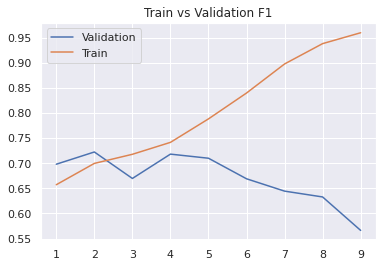

In [ ]:
plt.figure()
# plt.ylim(0.5, 1.1)
plt.title("Train vs Validation F1")
plt.plot(list(range(1,len(train_log) + 1)), [t["val_f1"] for t in train_log], label="Validation")
plt.plot(list(range(1,len(train_log) + 1)), [t["train_f1"] for t in train_log], label="Train")
plt.legend()

In [ ]:
model.eval()
true_labels, pred_labels, pred_probs = [], [], []
loss_sum, loss_ct = 0, 0
for X, y in (test):
  X, y = X.cuda(), y.cuda()
  optim.zero_grad()

  with torch.set_grad_enabled(False):
    outputs = model(X)
    _, pred = torch.max(outputs, 1)
    loss = crit(outputs, y)
    true_labels += y.cpu()
    pred_labels += pred.cpu()
    pred_probs += outputs[:,1]
    loss_sum += loss
    loss_ct += 1

loss_sum / loss_ct, accuracy_score(pred_labels, true_labels), f1_score(pred_labels, true_labels), roc_auc_score(true_labels, pred_probs)

(tensor(1.2348, device='cuda:0'), 0.7000842459983151, 0.6691449814126395)

In [ ]:
roc_auc_score(true_labels, pred_probs)

0.7661043338409157

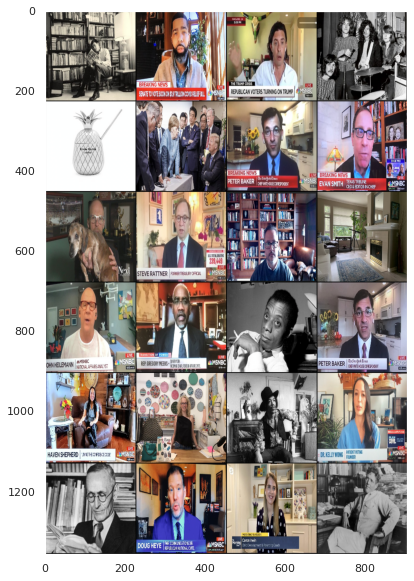

In [ ]:
images = [test.dataset[i][0] for i in np.argsort(pred_probs)[-24:]]

grid = utils.make_grid([denormalize(i, stdev, mean) for i in images], nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.grid(False)

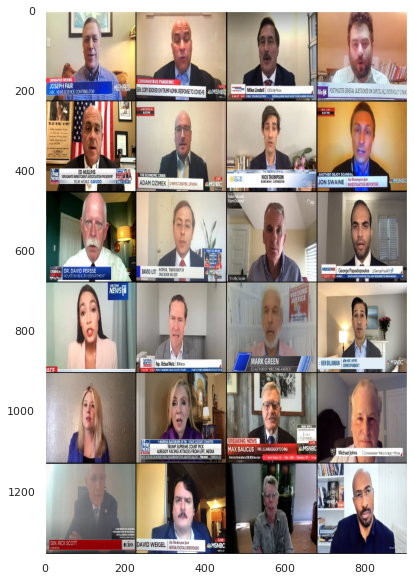

In [ ]:
images = [test.dataset[i][0] for i in np.argsort(pred_probs)[:24]]

grid = utils.make_grid([denormalize(i, stdev, mean) for i in images], nrow=4)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.grid(False)